# Problem definition

**Problem Definition:**

* It is a binary classification problem based on the graph data.
* The task is to predict the anticancer activity of a chemical compound using the chemical structure of the compound.

The chemical compound can be positive or negative against lung cancer cell and thus labelled as either 0 or 1.

**Define the data input and output:-**

* The data is in the form of graph which represents the chemical structure of the compound.
* Each sample of data contains information about the atoms and the connections between atoms of the molecule.
* So in this problem the features are the atoms and connections.
* The input file is structure data file (SDF). It contains information about the chemical composition of a molecule. SDF file store information about position of individual atom in the chemical compound and also tells about the connections.

**What is the experimental protocol used and how was it carried out?**

* The first step is to read the sdf file to get the information about the atoms and their connectivity in the compound. The atoms are described as nodes and connections are described as edges. The read_sdf method is used to read sdf file and the chemical composition of the compound.

* The nodes are given as characters. Thus it is treated as sequence of text data and best way to describe the text data sequence to tokenize the data and then adding the embeddig layer.

* Graph convolutional network is used to calculate the probability of the output class. Different methods differ in implementing message passing methods.

**What could be the challenges?** 

Developing a successful solution to our problem , complex data,datasets can include complex data elements ,another thing is that we have to make sure that our algorithm must be efficient and scalable to extract information from the big data and we should have enough knowledge and experience in order to use them if we needed to improve our algorithms.

**What data mining function is required?**

Tokenization when it comes to preprocessing in order to tokenize the data before adding the embeddig layer.

**What is the impact?**

It will make a great impact when it comes to medical field as it is going to predict wether chemical compunds are positive or negative in terms of lung cancer resistence

**What is an ideal solution?**

An ideal solution in my opinion will be measured in terms of metrics and performances


In [92]:
!pip install --quiet networkx
!pip install --quiet tf2_gnn

In [93]:
#importing libraries
import numpy as np   
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

#importing libraries for displaying network of molecule

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

#libraries for text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
from  tf2_gnn.layers.message_passing import RGAT,  MessagePassing, MessagePassingInput

#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense, Dropout #layers
from tensorflow.keras.optimizers import Adam #optimizer

import math
import pandas as pd 
%matplotlib inline
import seaborn as sns
#Set aesthetic parameters in one step.
sns.set()

In [94]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
        #split each sample alone by ($$$$)
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        #if the label : ==1 leave it as it is, if ==-1 make it 0.
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                #edge represent link between each two nodes
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [95]:
#reading train.sdf file
training_set = read_sdf('/kaggle/input/cisc873-dm-w23-a6/train.sdf')

#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.2)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [96]:

#reading test file
testing_set = read_sdf('/kaggle/input/cisc873-dm-w23-a6/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

# Visualizing/Inspecting a Sample

In [97]:
colors = cm.rainbow(np.linspace(0, 1, 50))

def visualize(sample):
  #initiating an instance of Graph
  G=nx.Graph()
  #all atoms as nodes
  nodes = sample[0]
  #all connections as edges
  edges = sample[1]
  #empty dictionary for labels for the all nodes
  labeldict={}
  #empty array for each node color
  node_color=[]
  for i,n in enumerate(nodes):
    #adding node to the graph each node as (0,1,2,3..)
    G.add_node(i)
    #dictionary building with [key,value] as [0:'C']
    labeldict[i]=n
    #color coding
    node_color.append(colors[hash(n)%len(colors)])

  # a list of nodes:
  for e in edges:
    #adding egde to the graph from one connection to other connection
    G.add_edge(e[0], e[1]) 

  #drawing the graph with labels for nodes as atoms and connections as edges    
  nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
  #draw the graph
  plt.show()
  #returns graph
  return G

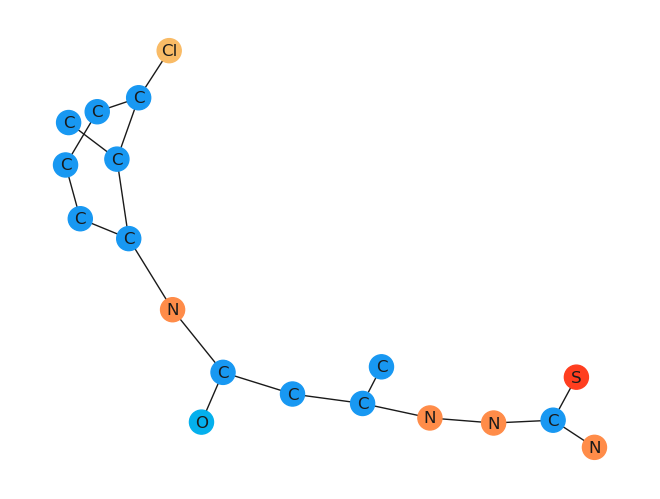

In [98]:
#displaying one sample
plt.clf()
visualize(training_set[5])

# Preprocessing

In [99]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [100]:
random.seed(0)

def prepare_single_batch(samples):
  #nodes characters array
  sample_nodes = [s[0] for s in samples]
  #tokenizing the sample nodes
  sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
  #pad_sequences for each sample node with post padding and post truncating 
  sample_nodes = pad_sequences(sample_nodes, padding='post', truncating = 'pre')
  #maximum length of nodes 
  max_nodes_len = np.shape(sample_nodes)[1]
  #defining edges
  edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
  edges = [e for e in edges if len(e) > 0]

  #array definition for segmented_ids
  node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
  
  #reshaping as 1 vector
  all_nodes = np.reshape(sample_nodes, -1)
  #concatenating all the edges as size [total_edges ,2]
  all_edges = np.concatenate(edges)

  node_to_graph = np.reshape(node_to_graph, -1)
  #returns a dictionary of features(data,edges,node2grah) and label
  return {
      'data': all_nodes,
      'edges': all_edges,
      'node2grah': node_to_graph,
  }, np.array([s[2] for s in samples]) 

In [101]:
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
      dataset = list(dataset)
      if shuffle:
        #randomly shuffling
        random.shuffle(dataset)
      
      #length of dataset
      l = len(dataset)
      #for creating batches from given dataset
      for ndx in range(0, l, batch_size):
        #creating batch samples with given batch_size
        batch_samples = dataset[ndx:min(ndx + batch_size, l)]
        #returning a generator with prepared batches
        yield prepare_single_batch(batch_samples)
        
      if not repeat:
          break

In [102]:

# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)        
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (200,)
edges
Shape is (133, 2)
node2grah
Shape is (200,)
label [0 0 0 0]


# build the model architecture

# **Trail_1**

In [32]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch

#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)


# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer is 32
params["hidden_dim"] = 32
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  
#gnn output layer 
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


In [33]:

#printing summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_2 (Embedding)        (None, 80)           40000       ['input_10[0][0]']           

In [43]:
#I will create Adam Optimizer for training optimizer with this hyperparameters
ad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [44]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = ad,
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [45]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 16 µs


In [46]:
#fit the models with 30 epoch and no early stopping
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)
print(hist)

Epoch 1/30
626/626 [==============================] - 18s 24ms/step - loss: 0.2692 - auc: 0.4262 - val_loss: 0.2110 - val_auc: 0.5067
Epoch 2/30
626/626 [==============================] - 15s 23ms/step - loss: 0.2018 - auc: 0.5520 - val_loss: 0.1974 - val_auc: 0.5906
Epoch 3/30
626/626 [==============================] - 15s 23ms/step - loss: 0.1926 - auc: 0.6077 - val_loss: 0.1938 - val_auc: 0.6626
Epoch 4/30
626/626 [==============================] - 15s 24ms/step - loss: 0.1858 - auc: 0.6641 - val_loss: 0.1929 - val_auc: 0.6192
Epoch 5/30
626/626 [==============================] - 15s 23ms/step - loss: 0.1820 - auc: 0.6861 - val_loss: 0.1846 - val_auc: 0.7158
Epoch 6/30
626/626 [==============================] - 15s 24ms/step - loss: 0.1807 - auc: 0.6925 - val_loss: 0.1810 - val_auc: 0.7144
Epoch 7/30
626/626 [==============================] - 14s 23ms/step - loss: 0.1804 - auc: 0.6888 - val_loss: 0.1826 - val_auc: 0.7010
Epoch 8/30
626/626 [==============================] - 15s 24ms

In [47]:

#make a prediction by using the model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 4s 5ms/step


In [48]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_2.csv')

#0.81299

**Expectation:**

This code defines a GNN (Graph Neural Network) model that takes in tokenized text data and predicts a binary classification label. The model has an input layer for the tokenized text data, an input layer for the edge data, and an input layer for the node-to-graph mapping. The tokenized text data is first embedded using an embedding layer, and then passed through a GNN layer. The output of the GNN layer is then passed through a dense layer with a sigmoid activation function to obtain the binary classification label.

**Observation:**
The code defines the input layers and sets the batch size for each input. It then creates an embedding layer to embed the tokenized text data. Next, it creates a GNNInput layer with the embedded data, the edge data, and the node-to-graph mapping. The GNNInput layer is passed through a GNN layer with hyperparameters defined by the params dictionary. Finally, the output of the GNN layer is passed through a dense layer with a sigmoid activation function to obtain the binary classification label.

**plan**

I will change my hyperparameters to :

params["hidden_dim"] = 32 
params["message_calculation_class"] = 'GGNN'

# Trial_2 (GGNN)

In [103]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 75)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32 
params["message_calculation_class"] = 'GGNN'
#params["num_edge_MLP_hidden_layers"] = 16

#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg)
#fc2 = Dense(64,activation='relu')(fc1)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_15/StatefulPartitionedCall:0', description="created by layer 'gnn_15'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_22/Sigmoid:0', description="created by layer 'dense_22'")


In [104]:
#printing summary of the model
model_2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_15 (TFOpLam  ()                  0           ['input_48[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_15 (Embedding)       (None, 75)           37500       ['input_46[0][0]']         

In [105]:
#I will create Adam Optimizer for training optimizer with this hyperparameters
ad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [106]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model_2.compile(
    optimizer = ad, 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [107]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

In [108]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_2 = model_2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    verbose=1
)
print(hist_2)

Epoch 1/30
626/626 [==============================] - 32s 42ms/step - loss: 0.2103 - auc: 0.5963 - val_loss: 0.1756 - val_auc: 0.6498
Epoch 2/30
626/626 [==============================] - 26s 41ms/step - loss: 0.1874 - auc: 0.6543 - val_loss: 0.1687 - val_auc: 0.6683
Epoch 3/30
626/626 [==============================] - 26s 41ms/step - loss: 0.1820 - auc: 0.6780 - val_loss: 0.1651 - val_auc: 0.6991
Epoch 4/30
626/626 [==============================] - 26s 41ms/step - loss: 0.1774 - auc: 0.7159 - val_loss: 0.1608 - val_auc: 0.7214
Epoch 5/30
626/626 [==============================] - 26s 42ms/step - loss: 0.1750 - auc: 0.7272 - val_loss: 0.1674 - val_auc: 0.6943
Epoch 6/30
626/626 [==============================] - 26s 41ms/step - loss: 0.1743 - auc: 0.7255 - val_loss: 0.1577 - val_auc: 0.7218
Epoch 7/30
626/626 [==============================] - 26s 41ms/step - loss: 0.1703 - auc: 0.7548 - val_loss: 0.1569 - val_auc: 0.7167
Epoch 8/30
626/626 [==============================] - 26s 42ms

In [109]:
#make a prediction by using the model
y_pred_2 = model_2.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_2 = np.reshape(y_pred_2, -1)

386/386 [==============================] - 7s 16ms/step


In [111]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('trial_GGNN_.csv')

# 0.818

**Expectation:**

* The first three lines define the three input layers for the model.
* The Embedding layer maps each token in the input data to a vector representation.
* The GNNInput layer is a custom Keras layer that allows the GNN layer to take in the graph structure information as input.
* The GNN layer is a graph neural network layer that applies a message-passing algorithm to the graph structure information and produces a graph-level output.
* The segment_mean layer takes in the graph-level output from the GNN layer and computes the mean of the output for each graph in the batch.
* The final Dense layer applies a non-linear transformation to the output of the segment_mean layer and produces a prediction with sigmoid activation.
* Finally, the input and output layers are combined into a Model instance.

**Observation:**

My model got a score of 0.818 on kaggle

**Plan**

I will change my hyperparameters to :

params["hidden_dim"] = 64

params["message_calculation_class"] = 'RGCN'

params["num_edge_MLP_hidden_layers"] = 16




# Trail_3 RGCN

In [20]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 50)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Convolutional Networks  
params["message_calculation_class"] = 'RGCN'
params["num_edge_MLP_hidden_layers"] = 16
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_3 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)


gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")


In [14]:
model_3.compile( loss='BinaryCrossentropy', metrics=['AUC'])

In [15]:
#printing summary of the model
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 50)           25000       ['input_1[0][0]']            

In [16]:
import math

batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
626/626 [==============================] - 66s 92ms/step - loss: 0.3418 - auc: 0.4630 - val_loss: 0.2332 - val_auc: 0.3633
Epoch 2/20
626/626 [==============================] - 56s 89ms/step - loss: 0.2152 - auc: 0.4404 - val_loss: 0.1842 - val_auc: 0.6571
Epoch 3/20
626/626 [==============================] - 56s 90ms/step - loss: 0.1942 - auc: 0.5995 - val_loss: 0.1974 - val_auc: 0.6351
Epoch 4/20
626/626 [==============================] - 57s 90ms/step - loss: 0.1933 - auc: 0.5900 - val_loss: 0.1995 - val_auc: 0.5964
Epoch 5/20
626/626 [==============================] - 56s 90ms/step - loss: 0.1921 - auc: 0.6178 - val_loss: 0.1891 - val_auc: 0.5701
Epoch 6/20
626/626 [==============================] - 56s 90ms/step - loss: 0.1906 - auc: 0.6239 - val_loss: 0.2046 - val_auc: 0.6262
Epoch 7/20
626/626 [==============================] - 56s 89ms/step - loss: 0.1913 - auc: 0.6121 - val_loss: 0.1890 - val_auc: 0.6200
Epoch 8/20
626/626 [==============================] - 56s 89ms

In [17]:

#make prediction on test data by using the trained model 
y_pred_3 = model_3.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_3 = np.reshape(y_pred_3, -1)

771/771 [==============================] - 14s 17ms/step


In [19]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_3})
submission.index.name = 'id'
submission.to_csv('submission_RGCN.csv')
#0.6756

**Expectation:**

* The first three lines define the three input layers for the model.
* The Embedding layer maps each token in the input data to a vector representation.
* The GNNInput layer is a custom Keras layer that allows the GNN layer to take in the graph structure information as input.
* The GNN layer is a graph neural network layer that applies a message-passing algorithm to the graph structure information and produces a graph-level output.
* The segment_mean layer takes in the graph-level output from the GNN layer and computes the mean of the output for each graph in the batch.
* The final Dense layer applies a non-linear transformation to the output of the segment_mean layer and produces a prediction with sigmoid activation.
* Finally, the input and output layers are combined into a Model instance.

**Observation:**

My model got a score of 0.6756 on kaggle

**Plan**

I will change my hyperparameters to :

params["hidden_dim"] = 32

params["message_calculation_class"] = 'RGAT'

params["num_edge_MLP_hidden_layers"] = 16

params["num_heads"] = 16

# Trial_4(RGAT)

In [27]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGAT'
params["num_edge_MLP_hidden_layers"] = 16
params["num_heads"] = 16
# params["num_layers"] = 4
# params["dense_every_num_layers"] = 4



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_4 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")


In [28]:
#printing summary of the model
model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_6[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_1 (Embedding)        (None, 70)           35000       ['input_4[0][0]']          

In [29]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_4.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
  

In [30]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

In [31]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_4 = model_4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist_4)

Epoch 1/30
626/626 [==============================] - 68s 79ms/step - loss: 0.2216 - auc: 0.5600 - val_loss: 0.1969 - val_auc: 0.6599
Epoch 2/30
626/626 [==============================] - 43s 68ms/step - loss: 0.1845 - auc: 0.6583 - val_loss: 0.1778 - val_auc: 0.6979
Epoch 3/30
626/626 [==============================] - 42s 68ms/step - loss: 0.1803 - auc: 0.6912 - val_loss: 0.1780 - val_auc: 0.7110
Epoch 4/30
626/626 [==============================] - 41s 66ms/step - loss: 0.1775 - auc: 0.7157 - val_loss: 0.1761 - val_auc: 0.7209
Epoch 5/30
626/626 [==============================] - 46s 73ms/step - loss: 0.1757 - auc: 0.7186 - val_loss: 0.1742 - val_auc: 0.7216
Epoch 6/30
626/626 [==============================] - 41s 66ms/step - loss: 0.1735 - auc: 0.7336 - val_loss: 0.1767 - val_auc: 0.7411
Epoch 7/30
626/626 [==============================] - 40s 65ms/step - loss: 0.1744 - auc: 0.7322 - val_loss: 0.1713 - val_auc: 0.7428
Epoch 8/30
626/626 [==============================] - 40s 64ms

In [55]:

#make a prediction by using the model
y_pred_4 = model_4.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_4 = np.reshape(y_pred_4, -1)

386/386 [==============================] - 8s 17ms/step


In [56]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_4})
submission.index.name = 'id'
submission.to_csv('trial_RGAT.csv')

**Expectation:**

 It starts by getting the default hyperparameters using the get_default_hyperparameters() method of the GNN class. It then sets the number of features per node to 32, the message-passing algorithm to use to 'RGAT', the number of hidden layers in the edge MLP to 16, and the number of attention heads to 16. These hyperparameters determine how the GNN layer will process the input graph data and propagate information through the graph, and can be adjusted to improve the performance of the GNN layer for a given task or dataset.

**Observation:**

My model got a score of 0.82838 on kaggle

**Plan**

I will change my hyperparameters to :

params["hidden_dim"] = 64

params["message_calculation_class"] = 'RGCN'

#  Trail_5 

In [32]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 50)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Convolutional Networks  
params["message_calculation_class"] = 'RGCN'
# params["num_edge_MLP_hidden_layers"] = 32
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='LeakyReLU')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_5 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)


gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")


In [33]:
#printing summary of the model
model_5.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_2 (Embedding)        (None, 50)           25000       ['input_7[0][0]']          

In [34]:
model_5.compile( loss='BinaryCrossentropy', metrics=['AUC'])

In [35]:
batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

In [36]:
model_5.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30
626/626 [==============================] - 31s 44ms/step - loss: 0.2314 - auc: 0.5385 - val_loss: 0.1974 - val_auc: 0.6087
Epoch 2/30
626/626 [==============================] - 27s 43ms/step - loss: 0.1900 - auc: 0.6525 - val_loss: 0.1785 - val_auc: 0.6950
Epoch 3/30
626/626 [==============================] - 27s 43ms/step - loss: 0.1855 - auc: 0.6723 - val_loss: 0.1770 - val_auc: 0.7034
Epoch 4/30
626/626 [==============================] - 27s 43ms/step - loss: 0.1813 - auc: 0.6983 - val_loss: 0.1723 - val_auc: 0.7274
Epoch 5/30
626/626 [==============================] - 27s 44ms/step - loss: 0.1785 - auc: 0.7170 - val_loss: 0.1725 - val_auc: 0.7254
Epoch 6/30
626/626 [==============================] - 29s 46ms/step - loss: 0.1764 - auc: 0.7213 - val_loss: 0.1728 - val_auc: 0.7367
Epoch 7/30
626/626 [==============================] - 29s 46ms/step - loss: 0.1743 - auc: 0.7339 - val_loss: 0.1959 - val_auc: 0.6983
Epoch 8/30
626/626 [==============================] - 27s 43ms

In [37]:
#make prediction on test data by using the trained model 
y_pred_5 = model_5.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_5 = np.reshape(y_pred_5, -1)
# 0.775

771/771 [==============================] - 7s 8ms/step


In [38]:
submission = pd.DataFrame({'label':y_pred_5})
submission.index.name = 'id'
submission.to_csv('submission_model_5.csv')

**Expectation:**

This code defines a neural network model that takes in tokenized text data, edge data, and node-to-graph mappings. It applies a graph neural network (GNN) layer to the data to build a graph structure, and produces a prediction using a final dense layer with sigmoid activation. The tf2_gnn library is used to import different types of message-passing algorithms for the GNN layer. The input and output layers are combined into a Model instance.

**I expect it will give me accuracy around 75**

**Observation:**

My model got a score of 0.775 on kaggle

**Plan**

**I plan to solve the problem of unbalanced data**

# Solve Unbalanced Data

In [39]:
#reading train.sdf file
training_set_T2 = read_sdf('/kaggle/input/cisc873-dm-w23-a6/train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [40]:
#checking for data balancing
np.unique(np.array(training_set_T2)[:,2],return_counts=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(array([0, 1], dtype=object), array([23806,  1218]))

In [41]:
#specify the length of the maximum freqent data to make the both labels have the same number of sample
len_0 = np.unique(np.array(training_set_T2)[:,2],return_counts=True)[1][0]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [42]:
len_0

23806

In [43]:
#convert the data from List to DataFrame to make upsampling
data = pd.DataFrame(np.array(training_set_T2)[:,:], columns = ['0', '1', 'target'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [44]:

from sklearn.utils import resample

resampling = data.copy()  #take a copy of dataframe to make resampling
class_0 = resampling[resampling['target']==0]   #specify all rows which has target zero
class_1 = resampling[resampling['target']==1]   #specify all rows which has target one
class_1_after = resample(class_1, replace=True,n_samples = len_0)   #add data records to data frame with value one to make the number of rows which has target 0 == number of rows whic has target 1
df_upsampled = pd.concat([class_0, class_1_after])    #add the new rows to the new data frame

In [45]:
# Display new class counts
df_upsampled['target'].value_counts()

0    23806
1    23806
Name: target, dtype: int64

In [46]:
#converting the upsampled DataFrame into list again to be easy to use the preprocessing methods on it
training_set_T2 = df_upsampled.values.tolist()

In [47]:
#splitting the train data into training and validation
training_set, validation_set = train_test_split(training_set_T2, test_size=0.15)
print(type(training_set))

<class 'list'>


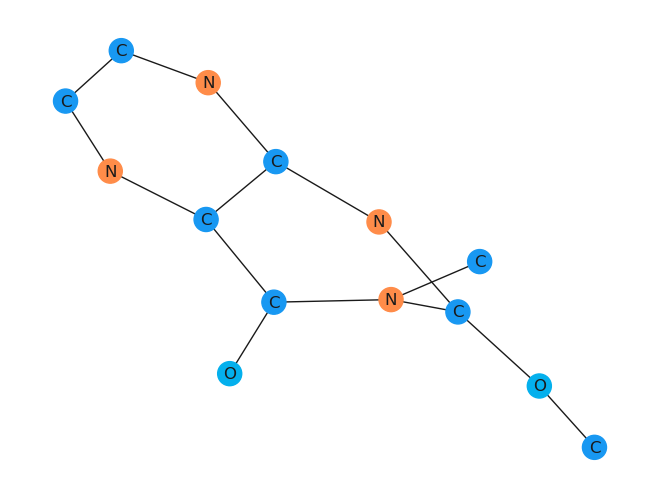

In [48]:

#displaying one sample
plt.clf()
visualize(training_set_T2[5])

# Preprocessing

In [49]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set_T2]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [50]:
# showing one batch:
for train_batch in gen_batch(training_set_T2, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)  
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (252,)
edges
Shape is (189, 2)
node2grah
Shape is (252,)
label [1 1 1 1]


In [54]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer

params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1

#params["num_edge_MLP_hidden_layers"] = 16

#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(256,activation='relu')(avg)
fc2 = Dense(128,activation='relu')(fc1)
fc3 = Dense(64,activation='relu')(fc2)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc3)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_6 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_14/Sigmoid:0', description="created by layer 'dense_14'")


In [55]:
#printing summary of the model
model_6.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_4 (Embedding)        (None, 70)           35000       ['input_13[0][0]']         

In [56]:
#I will create Adam Optimizer for training optimizer with this hyperparameters
ad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [57]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model_6.compile(
    optimizer = ad,
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [58]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 21.9 µs


In [59]:
#fit the models with 30 epoch and no early stopping
hist = model_6.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)
print(hist)

Epoch 1/30
1265/1265 [==============================] - 60s 43ms/step - loss: 0.6164 - auc: 0.7155 - val_loss: 0.5895 - val_auc: 0.7582
Epoch 2/30
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5824 - auc: 0.7563 - val_loss: 0.5788 - val_auc: 0.7754
Epoch 3/30
1265/1265 [==============================] - 51s 41ms/step - loss: 0.5698 - auc: 0.7705 - val_loss: 0.5771 - val_auc: 0.7691
Epoch 4/30
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5645 - auc: 0.7725 - val_loss: 0.5847 - val_auc: 0.7772
Epoch 5/30
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5505 - auc: 0.7883 - val_loss: 0.5395 - val_auc: 0.8111
Epoch 6/30
1265/1265 [==============================] - 55s 43ms/step - loss: 0.5338 - auc: 0.8067 - val_loss: 0.5124 - val_auc: 0.8287
Epoch 7/30
1265/1265 [==============================] - 51s 41ms/step - loss: 0.5182 - auc: 0.8208 - val_loss: 0.5073 - val_auc: 0.8312
Epoch 8/30
1265/1265 [==========================

In [60]:
#make a prediction by using the model
y_pred_6 = model_6.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_6 = np.reshape(y_pred_6, -1)

386/386 [==============================] - 6s 14ms/step


In [61]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_6})
submission.index.name = 'id'
submission.to_csv('trail_6.csv')

**Expectation:**

It applies a graph neural network (GNN) layer to the data to build a graph structure, and produces a prediction using a final dense layer with sigmoid activation. The hyperparameters for the GNN layer are defined, and the input and output layers are combined into a Model instance.

**I expect it will give me accuracy around 80**

**Observation:**

My model got a score of 0.8069 on kaggle

**Plan**

I will change my hyperparameters to :

params["message_calculation_class"] = 'RGCN'

params["hidden_dim"] = 40

params["num_aggr_MLP_hidden_layers"] = 2

params["num_edge_MLP_hidden_layers"] = 2

params["num_heads"] = 8

params["num_layers"] = 4

params["dense_every_num_layers"] = 1

params["film_parameter_MLP_hidden_layers"] = 1


# Trail_7 RGCN

In [132]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer

params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1

#params["num_edge_MLP_hidden_layers"] = 16

#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(256,activation='relu')(avg)
fc2 = Dense(128,activation='relu')(fc1)
fc3 = Dense(64,activation='relu')(fc2)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc3)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_7 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_21/StatefulPartitionedCall:0', description="created by layer 'gnn_21'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_12/SegmentMean:0', description="created by layer 'tf.math.segment_mean_12'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_31/Sigmoid:0', description="created by layer 'dense_31'")


In [133]:
#printing summary of the model
model_7.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_64 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_21 (TFOpLam  ()                  0           ['input_66[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_21 (Embedding)       (None, 70)           35000       ['input_64[0][0]']        

In [134]:

#compile the model by using my adam optimizer and BinaryCrossentropy loss
model_7.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [137]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 18.6 µs


In [138]:
#fit the models with 30 epoch and no early stopping
hist = model_7.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)
print(hist)

Epoch 1/30
1265/1265 [==============================] - 54s 43ms/step - loss: 0.6063 - auc: 0.7299 - val_loss: 0.5957 - val_auc: 0.7527
Epoch 2/30
1265/1265 [==============================] - 53s 42ms/step - loss: 0.5872 - auc: 0.7528 - val_loss: 0.5632 - val_auc: 0.7772
Epoch 3/30
1265/1265 [==============================] - 53s 42ms/step - loss: 0.5644 - auc: 0.7754 - val_loss: 0.5548 - val_auc: 0.7923
Epoch 4/30
1265/1265 [==============================] - 55s 44ms/step - loss: 0.5495 - auc: 0.7924 - val_loss: 0.5355 - val_auc: 0.8137
Epoch 5/30
1265/1265 [==============================] - 53s 42ms/step - loss: 0.5301 - auc: 0.8122 - val_loss: 0.5133 - val_auc: 0.8327
Epoch 6/30
1265/1265 [==============================] - 54s 43ms/step - loss: 0.5101 - auc: 0.8294 - val_loss: 0.4879 - val_auc: 0.8481
Epoch 7/30
1265/1265 [==============================] - 56s 44ms/step - loss: 0.4920 - auc: 0.8430 - val_loss: 0.4617 - val_auc: 0.8642
Epoch 8/30
1265/1265 [==========================

In [139]:
#make a prediction by using the model
y_pred_7 = model_7.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_7 = np.reshape(y_pred_7, -1)

386/386 [==============================] - 5s 12ms/step


In [140]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_7})
submission.index.name = 'id'
submission.to_csv('trial_7.csv')

#Kaggle==> 0.8339

**Expectation:**

The hyperparameters for the GNN layer are defined with a relational graph convolutional network (RGCN) message-passing algorithm, a hidden dimension of 40, 2 hidden layers for the edge and aggregation MLP, 8 attention heads, 4 layers, and a dense layer every 1 layer. The Embedding layer is set to embed each token as a 70-size vector. The final dense layer consists of three hidden dense layers with 256, 128, and 64 units, respectively. The input and output layers are combined into a Model instance.

**I expect it will give me accuracy around 82**

**Observation:**

My model got a score of 0.8339 on kaggle

**Plan**

I will change my hyperparameters to :

params["message_calculation_class"] = 'GNN_FiLM'

params["hidden_dim"] = 40

params["num_aggr_MLP_hidden_layers"] = 2

params["num_edge_MLP_hidden_layers"] = 2

params["num_heads"] = 8

params["num_layers"] = 4

params["dense_every_num_layers"] = 1

params["film_parameter_MLP_hidden_layers"] = 1

# Trial_8 GNN-FiLM

In [141]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer

params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)
# d1 = Dropout(0.2)(fc2)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_8 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_22/StatefulPartitionedCall:0', description="created by layer 'gnn_22'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_13/SegmentMean:0', description="created by layer 'tf.math.segment_mean_13'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_34/Sigmoid:0', description="created by layer 'dense_34'")


In [142]:
#printing summary of the model
model_8.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_67 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_22 (TFOpLam  ()                  0           ['input_69[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_22 (Embedding)       (None, 80)           40000       ['input_67[0][0]']        

In [143]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model_8.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [146]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 17.4 µs


In [147]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model_8.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
  #  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    # verbose=1
)
print(hist)

Epoch 1/30
1265/1265 [==============================] - 64s 50ms/step - loss: 0.5909 - auc: 0.7489 - val_loss: 0.5413 - val_auc: 0.8048
Epoch 2/30
1265/1265 [==============================] - 65s 52ms/step - loss: 0.5246 - auc: 0.8177 - val_loss: 0.4825 - val_auc: 0.8510
Epoch 3/30
1265/1265 [==============================] - 64s 51ms/step - loss: 0.4840 - auc: 0.8484 - val_loss: 0.4833 - val_auc: 0.8577
Epoch 4/30
1265/1265 [==============================] - 66s 52ms/step - loss: 0.4558 - auc: 0.8674 - val_loss: 0.4575 - val_auc: 0.8819
Epoch 5/30
1265/1265 [==============================] - 64s 51ms/step - loss: 0.4269 - auc: 0.8853 - val_loss: 0.3968 - val_auc: 0.9051
Epoch 6/30
1265/1265 [==============================] - 65s 51ms/step - loss: 0.3910 - auc: 0.9044 - val_loss: 0.3672 - val_auc: 0.9161
Epoch 7/30
1265/1265 [==============================] - 63s 50ms/step - loss: 0.3746 - auc: 0.9128 - val_loss: 0.3543 - val_auc: 0.9224
Epoch 8/30
1265/1265 [==========================

In [148]:
#make a prediction by using the model
y_pred_8 = model_8.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_8 = np.reshape(y_pred_8, -1)

386/386 [==============================] - 6s 14ms/step


In [149]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_8})
submission.index.name = 'id'
submission.to_csv('trial_8_GNN_FiLM.csv')
# 0.86

**Expectation:**

he hyperparameters for the GNN layer are defined with a GNN Feature-wise Linear Modulation (GNN_FiLM) message-passing algorithm, a hidden dimension of 40, 2 hidden layers for the edge and aggregation MLP, 8 attention heads, 4 layers, and a dense layer every 1 layer. The Embedding layer is set to embed each token as an 80-size vector. The final dense layer consists of two hidden dense layers with 64 and 32 units, respectively. The input and output layers are combined into a Model instance.

**I expect it will give me accuracy around 85**

**Observation:**

My model got a score of 0.86 on kaggle

**Plan**

I will change my hyperparameters to :


params["hidden_dim"] = 64 

params["message_calculation_class"] = 'gnn_edge_mlp'

params["num_aggr_MLP_hidden_layers"] = 4



# Trail_9 gnn_edge_mlp

In [70]:
#importing libraries
import tensorflow as tf
from tensorflow.math import segment_mean 
from tensorflow import keras
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Embedding, Dense 
from tensorflow.keras.optimizers import Adam 

#identify the 4 GNNInput inputs(data, edge, node2graph, num_graph)
data = keras.Input(batch_shape=(None,))                           #Input layer for nodes (tokenized text data)            
embeded = Embedding(tokenizer.num_words, 100)(data)               #embedding layer over data with each token embedded as  size vector 
# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)         #Input layer for edge data         
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)     #Input layer for node2graph ids    
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1                           #number of graphs (number of samples) 

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64 
#defining hidden dimension of the gnn layer(the output of all message passing layers)                   
params["message_calculation_class"] = 'gnn_edge_mlp'
params["num_aggr_MLP_hidden_layers"] = 4

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                     
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)    
print('pred:', pred)

#building model 
# input : dictionary of data,edges and node2graph
# output: prediction value from dense layer

model_9 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)


gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_16/Sigmoid:0', description="created by layer 'dense_16'")


In [71]:
model_9.summary() #display model's sumarry

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_9 (TFOpLamb  ()                  0           ['input_30[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_9 (Embedding)        (None, 100)          50000       ['input_28[0][0]']         

In [72]:
model_9.compile( #The compilation is performed using one single method call called compile() as it shows
    loss='BinaryCrossentropy', #loss parameter
    metrics=['AUC'] #metrics parameter
)

In [73]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 15 µs, sys: 1e+03 ns, total: 16 µs
Wall time: 21.5 µs


In [74]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model_9.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    # verbose=1
)
print(hist)

Epoch 1/30
1265/1265 [==============================] - 70s 52ms/step - loss: 0.6369 - auc: 0.6908 - val_loss: 0.6162 - val_auc: 0.7429
Epoch 2/30
1265/1265 [==============================] - 66s 52ms/step - loss: 0.5934 - auc: 0.7489 - val_loss: 0.5883 - val_auc: 0.7595
Epoch 3/30
1265/1265 [==============================] - 68s 54ms/step - loss: 0.5687 - auc: 0.7749 - val_loss: 0.5542 - val_auc: 0.7940
Epoch 4/30
1265/1265 [==============================] - 67s 53ms/step - loss: 0.5472 - auc: 0.7966 - val_loss: 0.5179 - val_auc: 0.8241
Epoch 5/30
1265/1265 [==============================] - 63s 50ms/step - loss: 0.5286 - auc: 0.8146 - val_loss: 0.5045 - val_auc: 0.8375
Epoch 6/30
1265/1265 [==============================] - 62s 49ms/step - loss: 0.5126 - auc: 0.8281 - val_loss: 0.4945 - val_auc: 0.8441
Epoch 7/30
1265/1265 [==============================] - 64s 50ms/step - loss: 0.4995 - auc: 0.8380 - val_loss: 0.4754 - val_auc: 0.8579
Epoch 8/30
1265/1265 [==========================

In [75]:
#make a prediction by using the model
y_pred_9 = model_9.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_9 = np.reshape(y_pred_9, -1)

386/386 [==============================] - 6s 15ms/step


In [76]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_9})
submission.index.name = 'id'
submission.to_csv('trial_9.csv')
# kaggel =0.82

**Expectation:**
The hyperparameters for the GNN layer are defined with a gnn_edge_mlp message-passing algorithm, a hidden dimension of 64, and 4 hidden layers for the aggregation MLP. The Embedding layer is set to embed each token as a 100-size vector. The final dense layer consists of a single dense layer with sigmoid activation function. The input and output layers are combined into a Model instance.

**I expect it will give me accuracy around 84**

**Observation:**

My model got a score of 0.82 on kaggle

**Plan**

I will change my hyperparameters to :

params["hidden_dim"] = 64
  
params["message_calculation_class"] = 'RGCN'

# Trail_10 RGCN

In [82]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 50)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Convolutional Networks  
params["message_calculation_class"] = 'RGCN'
# params["num_edge_MLP_hidden_layers"] = 32
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='LeakyReLU')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_10 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_14/StatefulPartitionedCall:0', description="created by layer 'gnn_14'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_20/Sigmoid:0', description="created by layer 'dense_20'")


In [83]:
model_10.summary() #display model's sumarry

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_14 (TFOpLam  ()                  0           ['input_45[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_14 (Embedding)       (None, 50)           25000       ['input_43[0][0]']         

In [84]:
model_10.compile( #The compilation is performed using one single method call called compile() as it shows
    loss='BinaryCrossentropy', #loss parameter
    metrics=['AUC'] #metrics parameter
)

In [85]:
%%time
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

CPU times: user 159 µs, sys: 10 µs, total: 169 µs
Wall time: 175 µs


In [86]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model_10.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    # verbose=1
)
print(hist)

Epoch 1/30
1265/1265 [==============================] - 66s 49ms/step - loss: 0.6424 - auc: 0.6753 - val_loss: 0.6270 - val_auc: 0.7323
Epoch 2/30
1265/1265 [==============================] - 64s 51ms/step - loss: 0.5919 - auc: 0.7488 - val_loss: 0.5719 - val_auc: 0.7772
Epoch 3/30
1265/1265 [==============================] - 63s 50ms/step - loss: 0.5666 - auc: 0.7771 - val_loss: 0.5539 - val_auc: 0.7968
Epoch 4/30
1265/1265 [==============================] - 62s 49ms/step - loss: 0.5468 - auc: 0.7963 - val_loss: 0.5372 - val_auc: 0.8185
Epoch 5/30
1265/1265 [==============================] - 67s 53ms/step - loss: 0.5282 - auc: 0.8144 - val_loss: 0.5109 - val_auc: 0.8327
Epoch 6/30
1265/1265 [==============================] - 65s 51ms/step - loss: 0.5151 - auc: 0.8259 - val_loss: 0.4880 - val_auc: 0.8493
Epoch 7/30
1265/1265 [==============================] - 64s 50ms/step - loss: 0.5018 - auc: 0.8363 - val_loss: 0.4800 - val_auc: 0.8549
Epoch 8/30
1265/1265 [==========================

In [87]:
#make a prediction by using the model
y_pred_10 = model_10.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_10 = np.reshape(y_pred_10, -1)

386/386 [==============================] - 6s 14ms/step


In [91]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_10})
submission.index.name = 'id'
submission.to_csv('trial_10_.csv')
# 0.826

**Expectation:**

The hyperparameters for the GNN layer are defined with a RGCN message-passing algorithm, a hidden dimension of 64. The Embedding layer is set to embed each token as a 50-size vector. The final dense layer consists of a single dense layer with sigmoid activation function. The input and output layers are combined into a Model instance.

**I expect it will give me accuracy around 84**

**Observation:**
My model got a score of 0.826 on kaggle



# SO the best Trial , it will be trail_8

**0.86 in kaggel**

# ** Answer the questions**

-----------------------------
-------------------------------

# **Based on the provided template, describe the format of the input file (sdf file).**

The input file is structure data file (SDF). It contains information about the chemical composition of a molecule. SDF file store information about position of individual atom in the chemical compound and also tells about the connections. Different molecules are delimited by$$$$expression.

-----------------------

Each sample/molecule starts with header which tells about the name/title of the compound. Other sections includes information about Atom count, version number, connections etc. Atom block tells about the elements of the compound. Bond block block tells about the bonding structure of the compound. These both blocks are used in this assignment to get information about the compound and saving them in form of edges and nodes. Each node is the atom given in the chemical molecule.

# **What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

**The input tensors in this network are:**

* data: The data contains the nodes of the chemical compound in the tokenized form. Nodes for each compound are extracted, then they are tokenized using the tokenizer and finally padding is done using pad_sequence method. The shape for each batch is [batch_size*max_len_nodes], where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.

---------------------------

* edge: edge is the input tensor which carries information about connections between atoms. The shape of edge is [sum_of_all_edges,2]. The sum_of_all_edges represents the sum(no. of edges of each sample) of the batch_size. For example in a batch of 3 samples, the number of edges in sample 1: 21, sample 2: 20 and sample 3: 40. So the size of edge tensor would be [81,2].

------------------------

* node2graph: It is the input tensor which is used for segmented mean and contains information about segmented ids. The shape for each batch is [batch_size*max_len_nodes], where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.

---------------------



# **For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

* gnn_out: The gnn_out is of shape [batch_size_node_dimension,hidden layers], where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). It represents the aggregation output of the model for each hidden layer.

----------------------------

* avg: Average takes the segmented mean of the gnn_out based on the segmented ids. For each sample in the batch_size, the output of gnn_out is [tokenized_vector_dimension, hidden_layers]. Each sample has one segment id. Thus the segment_mean takes the mean of all the output data in the gnn_out output and represents one sample with one number for each hidden layer. The final output of the avg tensor is of shape [batch_size, hidden_layer]. It is a way of collecting information for each sample and representing it in the form of mean data.

# **What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

* segment_mean takes the mean of the data which have same segmented ids.

* reduce_mean: computes the mean of elements across dimensions of a tensor given the arguments.

Use TensorFlow reduce_mean operation to calculate the mean of tensor elements along various dimensions of the tensor.

* pred: The final output (pred) tells about the probability of a chemical compound to be active for the cancer cell or not. The shape of pred is [batch_size,1]. Thus for each sample, the final output is a number which represents the probability associated with each chemical compound about its activity.

# **What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

* The default template implements the default setting of the number of layers in the gcn network.
* The default layer are 4 as given in the documentaion.
* The default message passing method is rgcn (Graph convolution layers).
* Using multiple gcn helps in incorporating all the graph complexity properly and thus creates a better model.